In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import pandas as pd
import sys
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
def get_prob_maps_list(prob_map):
    num_classes = 13
    probs_list = []

    for i in prob_map.items():

        for label in range(num_classes):
            probs_list.append(i[1][label][0])

    prob_img = np.zeros((num_classes, 691, 691))
    _, rows, cols = prob_img.shape

    for i in range(rows):
        for j in range(cols):

            prob_img[:, i, j] = np.array([probs_list[label][i, j] for label in range(num_classes)])

    return prob_img

In [79]:
def calculate_ece(y_true, y_pred, num_bins=10):
        
    pred_y = np.argmax(y_pred, axis=-1)
    correct = (pred_y == y_true.astype(np.float32))
    prob_y = np.max(y_pred, axis=-1)

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    bins = np.digitize(prob_y, bins=b, right=True)

    o = 0
    for b in range(num_bins):
        mask = bins == b
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - prob_y[mask]))

    print(o / y_pred.shape[0])

    x = prob_y[mask]
    y = correct[mask]

    return x, y

def calculate_sce(y_true, y_pred, num_bins=10):
    
    classes = y_pred.shape[-1]

    o = 0
    for cur_class in range(classes):
        correct = (cur_class == y_true).astype(np.float32)
        prob_y = y_pred[..., cur_class]

        b = np.linspace(start=0, stop=1.0, num=num_bins)
        bins = np.digitize(prob_y, bins=b, right=True)

        for b in range(num_bins):
            mask = bins == b
            if np.any(mask):
                o += np.abs(np.sum(correct[mask] - prob_y[mask]))

    print(o / (y_pred.shape[0] * classes))

    x = prob_y[mask]
    y = correct[mask]

    return x, y

In [80]:
def reliability_diagram(x, y):

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(x, y, "s-", label="CNN")

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.title("Reliability diagram / calibration curve")

    plt.tight_layout()
    plt.show()

Checking  NLDAMPH0005_1_frame0_003.npz NLDAMPH0005_1_frame0_003.nii.gz
0.1419122104813065


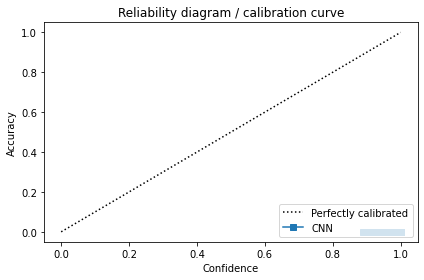

In [81]:
preds_path = r'Z:\grodriguez\CardiacOCT\preds-test-set\predicted_results_model4_2d_with_maps'
orig_path = r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task504_CardiacOCT\labelsTs'

preds_list = os.listdir(preds_path)
orig_list = os.listdir(orig_path)

for orig in orig_list:

    frame_name = orig.split('.')[0]
    files_for_frame = []

    for pred in preds_list:
        
        if frame_name in pred:
            files_for_frame.append(pred)

    npz_file = [npz for npz in files_for_frame if npz.endswith('npz')][0]
    nifti_file = [nifti for nifti in files_for_frame if nifti.endswith('nii.gz')][0]

    print('Checking ', npz_file, nifti_file)
    pred_seg = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\preds-test-set\predicted_results_model4_2d_with_maps\{}'.format(nifti_file))
    pred_seg_data = sitk.GetArrayFromImage(pred_seg)[0]
    orig_seg = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task504_CardiacOCT\labelsTs\{}'.format(nifti_file))
    orig_seg_data = sitk.GetArrayFromImage(orig_seg)[0]
    prob_map = np.load(r'Z:\grodriguez\CardiacOCT\preds-test-set\predicted_results_model4_2d_with_maps\{}'.format(npz_file))

    
    _, prob_img = get_prob_maps_list(prob_map)

    true_seg_crop = orig_seg_data[6:697, 6:697]
    pred_seg_crop = pred_seg_data[6:697, 6:697]

    x, y = calculate_sce(true_seg_crop.reshape(-1), prob_img.reshape(691*691, 13))
    reliability_diagram(x, y)

    break
